* **Student**: Miki Seltzer, Minhchau Dang, Kuan Lin, Alejandro Rojas, Ricardo Barrera
* **Email Address**: miki.seltzer@berkeley.edu, minhchau.dang@berkeley.edu, kuanlin@ischool.berkeley.edu, ale@ischool.berkeley.edu, ricardofrank@ischool.berkeley.edu
* **Course**: 2016-0111 DATASCI W261: Machine Learning at Scale
* **Section**: Spring 2016, Section 2
* **Assignment**: Homework 13, Week 13
* **Submission Date**: April 28, 2016

# Helper utilities

## Notebook imports

If the following cell (which imports all the Python packages used by the different drivers) doesn't run, some of the drivers and helper functions in the notebook will also fail to run. Note that you will also need `pyspark` to run the actual jobs themselves.

In [ ]:
%matplotlib inline

In [ ]:
from __future__ import division
from collections import defaultdict
from datetime import datetime
import functools
from math import exp, log
import matplotlib
import matplotlib.pyplot as plt
import numpy
import operator
import os
import pandas
import seaborn
import subprocess
import sys
import time

## Set Cluster Size

Using r3.xlarge nodes, there is 23424 MB of available memory for Yarn scheduling and there are 4 cores per server.

* http://www.ec2instances.info
* http://docs.aws.amazon.com/ElasticMapReduce/latest/ReleaseGuide/emr-hadoop-task-config.html

In [ ]:
node_count = 10
yarn_memory = 20000
executors_per_node = 2

## Set Cluster Name

In [ ]:
cluster_name = 'Week13_Cluster'

## Initialize Spark

Use the ``findspark`` library in order to help setup the Spark context. This allows the same code to work across different versions of Spark.

https://github.com/minrk/findspark

In [ ]:
import findspark
findspark.init()

import pyspark
from pyspark import SparkConf, SparkContext

Compute the configuration for our cluster.

In [ ]:
server_cores = int(subprocess.check_output('nproc'))
memory_per_executor = int((yarn_memory / executors_per_node) / 1.1)
cores_per_executor = int(int(server_cores) / executors_per_node)
executor_count = executors_per_node * node_count

conf = SparkConf()

conf.setAppName(cluster_name)
conf.setMaster('yarn-client')
conf.set('spark.dynamicAllocation.enabled', False)
conf.set('spark.executor.cores', cores_per_executor)
conf.set('spark.executor.memory', str(memory_per_executor) + 'M')
conf.set('spark.yarn.executor.memoryOverhead', int(memory_per_executor / 10))
conf.set('spark.executor.instances', executor_count)

print conf.toDebugString()

sc = SparkContext(conf=conf)

spark.app.name=Week13_Cluster
spark.dynamicAllocation.enabled=False
spark.eventLog.dir=hdfs:///spark-history
spark.eventLog.enabled=true
spark.executor.cores=2
spark.executor.instances=20
spark.executor.memory=9090M
spark.history.fs.logDirectory=hdfs:///spark-history
spark.history.kerberos.keytab=none
spark.history.kerberos.principal=none
spark.history.provider=org.apache.spark.deploy.history.FsHistoryProvider
spark.history.ui.port=18080
spark.master=yarn-client
spark.submit.deployMode=client
spark.yarn.containerLauncherMaxThreads=25
spark.yarn.driver.memoryOverhead=384
spark.yarn.executor.memoryOverhead=909
spark.yarn.historyServer.address=ip-172-31-34-197.us-west-2.compute.internal:18080
spark.yarn.max.executor.failures=3
spark.yarn.preserve.staging.files=false
spark.yarn.queue=default
spark.yarn.scheduler.heartbeat.interval-ms=5000
spark.yarn.submit.file.replication=3


# HW 13.1: Spark implementation of basic PageRank

> Write a basic Spark implementation of the iterative PageRank algorithm
that takes sparse adjacency lists as input.

> Make sure that your implementation utilizes teleportation (1-damping/the number of nodes in the network),
and further, distributes the mass of dangling nodes with each iteration
so that the output of each iteration is correctly normalized (sums to 1).

> [NOTE: The PageRank algorithm assumes that a random surfer (walker), starting from a random web page,
chooses the next page to which it will move by clicking at random, with probability $d$,
one of the hyperlinks in the current page. This probability is represented by a so-called
'damping factor' $d$, where $d \in (0, 1)$. Otherwise, with probability $(1 − d)$, the surfer
jumps to any web page in the network. If a page is a dangling end, meaning it has no
outgoing hyperlinks, the random surfer selects an arbitrary web page from a uniform
distribution and "teleports" to that page]

> In your Spark solution, please use broadcast variables and caching to make sure your code is as efficient as possible.

## Identify dangling nodes

Graph files only list nodes with outgoing links, so any counts will be inaccurate unless they also have the nodes that have zero outgoing links (dangling nodes). The following code attempts to create the entire graph so that these nodes can be factored in for counting.

In [ ]:
# Utility functions which will expand neighbors as a list and collapse pairs
# of neighbor dictionaries into a single dictionary

def getNeighborNames(x):
    name, neighbors = x
    return [str(neighbor) for neighbor in neighbors.iterkeys()]

def asDanglingNode(x):
    return x, {}

def getTrueNeighbors(x, y):
    if len(x) == 0:
        return y
    return x

# Utility function which will construct a new RDD with all dangling nodes
# added to the graph.

def getCompleteAdjacencyList(leftRDD, rightRDD=None):
    leftTableRDD = leftRDD

    # Convert the right table into the left table (identifies dangling nodes)
    # if no right table is provided. Otherwise, reuse the same format.

    if rightRDD is None:
        rightTableRDD = leftRDD.flatMap(getNeighborNames).distinct().map(asDanglingNode)
    else:
        rightTableRDD = rightRDD.map(lambda x: (x[0], {}))

    return leftTableRDD.union(rightTableRDD) \
        .reduceByKey(getTrueNeighbors) \
        .cache()

## Apply PageRank to adjacency list RDD

Next, given a complete graph, we'll run the page rank algorithm. The goal is to boost performance as much as possible by caching each intermediate RDD (to avoid having to serialize it to disk), using broadcast variables and accumulators, and reducing the number of transformations.

In [ ]:
# Perform one iteration of page rank

def pageRankIteration(dataRDD, pageRankRDD, nodeCountValue, dampingFactorValue, danglingMassValue):

    # Compute the bonus mass that we will add to each node (compute this
    # in advance so that we can broadcast it during the initial map phase
    # and avoid unnecessary transformations).

    teleportMassValue = (1.0 - dampingFactorValue) / nodeCountValue
    dampedDanglingMassValue = (danglingMassValue * dampingFactorValue) / nodeCountValue

    dampingFactor = sc.broadcast(dampingFactorValue)
    bonusMass = sc.broadcast(teleportMassValue + dampedDanglingMassValue)

    # Function to distribute the probability mass

    danglingMass = sc.accumulator(0.0)

    def distributeProbabilityMass(x):
        name, values = x
        neighbors, mass = values

        neighborCount = len(neighbors)

        # Normally we would just indicate that we have 0.0 mass from our node,
        # but the reality is we actually already know that we will have the
        # guaranteed mass from the teleport and dangling nodes.

        nodeData = [(name, bonusMass.value)]

        if neighborCount == 0:
            danglingMass.add(mass)
            return nodeData

        # Multiply the distributed mass by the damping factor here rather than
        # as a separate step.

        distributedMass = (mass / neighborCount) * dampingFactor.value

        nodeDistributedMass = [
            (neighbor, distributedMass)
                 for neighbor in neighbors.iterkeys()
        ]

        return nodeData + nodeDistributedMass

    # Perform one iteration of page rank

    newPageRankRDD = dataRDD.join(pageRankRDD, numPartitions=dataRDD.getNumPartitions()) \
        .flatMap(distributeProbabilityMass) \
        .reduceByKey(operator.add) \
        .cache()

    newPageRankRDD.count()
    danglingMassValue = danglingMass.value

    return danglingMassValue, newPageRankRDD

# Iterate page rank for the given number of iterations

def pageRank(dataRDD, pageRankRDD, danglingMassValue, iterationCount, debugIterationChanges):
    times = []

    now = datetime.today()
    print now, 'Materializing node count'

    nodeCountValue = dataRDD.count()

    if pageRankRDD is None:
        initialMassValue = 1.0 / nodeCountValue
        initialMass = sc.broadcast(initialMassValue)

        danglingMass = sc.accumulator(0.0)

        def getInitialPageRank(x):
            name, neighbors = x

            if len(neighbors) == 0:
                danglingMass.add(initialMass.value)

            return name, initialMass.value

        oldPageRankRDD = dataRDD.map(getInitialPageRank).cache()
        oldPageRankRDD.count()

        danglingMassValue = danglingMass.value
    else:
        oldPageRankRDD = pageRankRDD

    now = datetime.today()
    print now, 'Started page rank computation'

    for i in range(0, iterationCount):
        if debugIterationChanges:
            now = datetime.today()
            print now, 'Iteration', i + 1, 'started'

        started = time.time()

        danglingMassValue, newPageRankRDD = pageRankIteration(
            dataRDD, oldPageRankRDD, nodeCountValue, 0.85, danglingMassValue)

        finished = time.time()

        times.append(finished - started)

        # Update to the new page rank

        oldPageRankRDD.unpersist()
        oldPageRankRDD = newPageRankRDD

    now = datetime.today()
    print now, 'Finished page rank computation'

    return times, danglingMassValue, newPageRankRDD

## Acquire test network

> As you build your code, use the test data

> * s3://ucb-mids-mls-networks/PageRank-test.txt

> Or under the Data Subfolder for HW7 on Dropbox with the same file name.

> (On Dropbox https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0)

In [ ]:
if not os.path.isfile('PageRank-test.txt'):
    !wget -qq https://www.dropbox.com/sh/2c0k5adwz36lkcw/AADxzBgNxNF5Q6-eanjnK64qa/PageRank-test.txt
    !hdfs dfs -copyFromLocal PageRank-test.txt

## Add test network dangling nodes

Use ``count`` in order to materialize the RDD so that the time to load the RDDs in these stages don't affect the computation time.

In [ ]:
def parseLine(x):
    name, value = x.split('\t', 1)
    return str(name), eval(value)

In [ ]:
testDataRDD = sc.textFile('PageRank-test.txt').map(parseLine).cache()
print testDataRDD.count()

10


In [ ]:
testCompleteAdjacencyListRDD = getCompleteAdjacencyList(testDataRDD)
print testCompleteAdjacencyListRDD.count()

11


## Provide a way to plot time elapsed

In [ ]:
def plotTimes(t):
    plt.scatter(range(1, len(t) + 1), t, marker='o')
    plt.plot(range(1, len(t) + 1), t)
    plt.title('Length of time per iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Time (sec)')
    plt.xlim(0,len(t) + 1)
    plt.grid(True)

## Execute PageRank on test network

> With teleportation parameter set to 0.15 (1-d, where d, the damping factor is set to 0.85), and crosscheck
your work with the true result, displayed in the first image
in the Wikipedia article:

> https://en.wikipedia.org/wiki/PageRank

### Cross-check PageRank test data result locally

> Run this experiment locally first. Report the local configuration that you used and how long in minutes and seconds it takes to complete your job.

Running it locally is the same as running it with just one partition. Therefore, repartition the data so that there is just one and run the page rank algorithm.

In [ ]:
%time testPageRankTimes, testDanglingMass, testPageRankResult = pageRank( \
    testCompleteAdjacencyListRDD.partitionBy(1), None, 0.0, 40, False)

2016-04-28 06:23:03.002564 Materializing node count
2016-04-28 06:23:03.515883 Started page rank computation
2016-04-28 06:23:17.749581 Finished page rank computation
CPU times: user 809 ms, sys: 150 ms, total: 959 ms
Wall time: 14.8 s


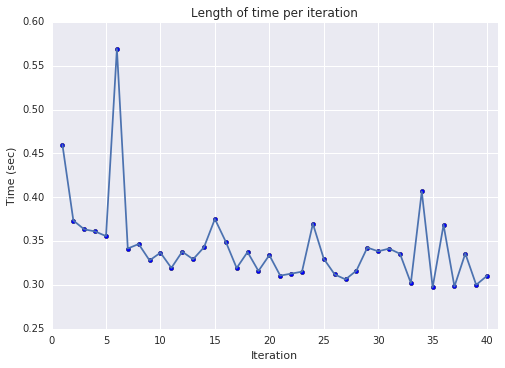

In [ ]:
plotTimes(testPageRankTimes)

Essentially this is run with the cluster configuration reported above, but on just one executor (thus emulating a local run of the code).

* **Instance Type**: [Memory Optimized](https://aws.amazon.com/ec2/instance-types/#memory-optimized)
* **Instance Class**: r3.xlarge
* **Job Completion Time**: 15 seconds

### Cross-check PageRank test data result on AWS

> Repeat this experiment on AWS. Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete your job. (in your notebook, cat the cluster config file)

In [ ]:
%time testPageRankTimes, testDanglingMass, testPageRankResult = pageRank( \
    testCompleteAdjacencyListRDD, None, 0.0, 40, False)

2016-04-28 06:23:18.043424 Materializing node count
2016-04-28 06:23:18.276046 Started page rank computation
2016-04-28 06:23:33.325536 Finished page rank computation
CPU times: user 781 ms, sys: 287 ms, total: 1.07 s
Wall time: 15.3 s


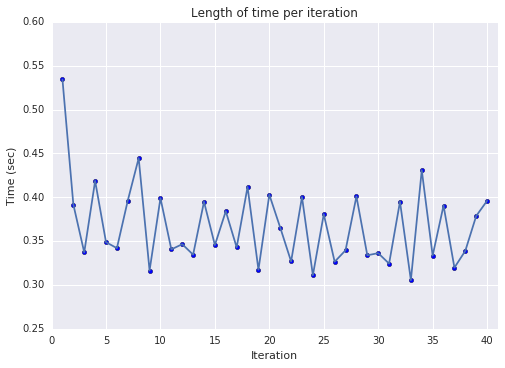

In [ ]:
plotTimes(testPageRankTimes)

* **Instance Type**: [Memory Optimized](https://aws.amazon.com/ec2/instance-types/#memory-optimized)
* **Instance Class**: r3.xlarge
* **Cluster Size**: 10 nodes
* **Job Completion Time**: 15 seconds

### Confirm the PageRank test data matches

> Here for reference are the corresponding PageRank probabilities:

> ```
    A,0.033
    B,0.384
    C,0.343
    D,0.039
    E,0.081
    F,0.039
    G,0.016
    H,0.016
    I,0.016
    J,0.016
    K,0.016
```

In [ ]:
[(x[0], '%0.3f' % x[1]) for x in testPageRankResult.sortByKey().collect()]

[('A', '0.033'),
 ('B', '0.384'),
 ('C', '0.343'),
 ('D', '0.039'),
 ('E', '0.081'),
 ('F', '0.039'),
 ('G', '0.016'),
 ('H', '0.016'),
 ('I', '0.016'),
 ('J', '0.016'),
 ('K', '0.016')]

# HW 13.2: Applying PageRank to the Wikipedia hyperlinks network

> The dataset is built from the Sept. 2015 XML snapshot of English Wikipedia.
For this directed network, a link between articles:

> ```
A -> B
```

> is defined by the existence of a hyperlink in A pointing to B.
This network also exists in the indexed format:

> * Data: s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt
> * Data: s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-in.txt
> * Data: s3://ucb-mids-mls-networks/wikipedia/indices.txt

> but has an index with more detailed data:

> ```
(article name) \t (index) \t (in degree) \t (out degree)
```

> In the dictionary, target nodes are keys, link weights are values .
Here, a weight indicates the number of time a page links to another.
However, for the sake of this assignment, treat this an unweighted network,
and set all weights to 1 upon data input.

## Download Wikipedia data set

In [ ]:
if not os.path.isfile('all-pages-indexed-out.txt'):
    !aws s3 cp s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt .
    !hdfs dfs -copyFromLocal all-pages-indexed-out.txt

if not os.path.isfile('all-pages-indexed-in.txt'):
    !aws s3 cp s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-in.txt .
    !hdfs dfs -copyFromLocal all-pages-indexed-in.txt

## Add Wikipedia network dangling nodes

Use ``count`` in order to materialize the RDD so that the time to load the RDDs in these stages don't affect the computation time.

In [ ]:
wikipediaOutgoingRDD = \
    sc.textFile('all-pages-indexed-out.txt') \
        .map(parseLine) \
        .cache()

wikipediaIncomingRDD = \
    sc.textFile('all-pages-indexed-in.txt') \
        .map(parseLine) \
        .cache()

print wikipediaOutgoingRDD.count()
print wikipediaIncomingRDD.count()

5781290
14216021


Since the graph is large, we'll also want to know how long it takes to fill in the missing nodes of the graph.

In [ ]:
wikipediaCompleteAdjacencyListRDD = getCompleteAdjacencyList(wikipediaOutgoingRDD, wikipediaIncomingRDD)
%time wikipediaCompleteAdjacencyListRDD.count()

CPU times: user 14.9 ms, sys: 2.27 ms, total: 17.2 ms
Wall time: 1min 16s


15192277

## Execute PageRank on Wikipedia network

### 10 Iterations - Execution

> Run your Spark PageRank implementation on the Wikipedia dataset for 10 iterations,
and display the top 100 ranked nodes (with alpha = 0.85).

In [ ]:
%time wikipedia10PageRankTimes, wikipedia10DanglingMass, wikipedia10PageRankResult = \
    pageRank(wikipediaCompleteAdjacencyListRDD, None, 0.0, 10, True)

2016-04-28 06:27:33.980714 Materializing node count
2016-04-28 06:27:40.852787 Started page rank computation
2016-04-28 06:27:40.852925 Iteration 1 started
2016-04-28 06:31:58.024892 Iteration 2 started
2016-04-28 06:35:29.574986 Iteration 3 started
2016-04-28 06:39:00.576113 Iteration 4 started
2016-04-28 06:42:33.583153 Iteration 5 started
2016-04-28 06:45:56.733466 Iteration 6 started
2016-04-28 06:49:25.194844 Iteration 7 started
2016-04-28 06:52:34.138123 Iteration 8 started
2016-04-28 06:55:53.033017 Iteration 9 started
2016-04-28 06:59:22.791116 Iteration 10 started
2016-04-28 07:02:45.033696 Finished page rank computation
CPU times: user 379 ms, sys: 143 ms, total: 521 ms
Wall time: 35min 11s


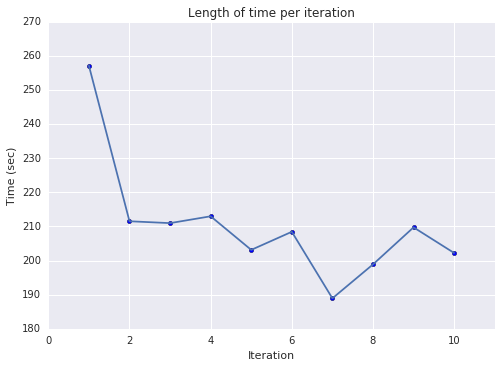

In [ ]:
plotTimes(wikipedia10PageRankTimes)

### 10 Iterations - Top 100

Now we take the top 100 page rank values.

In [ ]:
wikipedia10Top100PageRanks = wikipedia10PageRankResult.takeOrdered(100, lambda x: -x[1])
wikipedia10Top100PageRankValues = { x[0]: x[1] for x in wikipedia10Top100PageRanks } 

Load the indices so that we can have something that is more human-readable.

In [ ]:
if not os.path.isfile('indices.txt'):
    !aws s3 cp s3://ucb-mids-mls-networks/wikipedia/indices.txt .
    !hdfs dfs -copyFromLocal indices.txt

download: s3://ucb-mids-mls-networks/wikipedia/indices.txt to ./indices.txt


In [ ]:
wikipediaIndicesRDD = sc.textFile('indices.txt')

Perform a hash join of the indices with the top 100 IDs, which we can achieve in a more performant way by broadcasting the tables and generating the join via a filter followed by a map.

In [ ]:
def getNamedPageRanks(top100PageRankValues):
    global wikipediaIndicesRDD

    top100PageRanks = sc.broadcast(top100PageRankValues)

    def isTop100Index(x):
        pageId = x.split('\t')[1]
        return pageId in top100PageRanks.value

    def getPageRank(x):
        pageName, pageId, values = x.split('\t', 2)
        return pageName, top100PageRanks.value[pageId]

    return wikipediaIndicesRDD \
        .filter(isTop100Index) \
        .map(getPageRank) \
        .takeOrdered(100, lambda x: -x[1])

pandas.set_option('display.max_rows', 100)

wikipedia10 = pandas.DataFrame( \
    getNamedPageRanks(wikipedia10Top100PageRankValues), \
    columns=['Page Name', 'PageRank'])

wikipedia10.to_csv('wikipedia10.csv')
wikipedia10

,Page Name,PageRank
0,United States,0.001532
1,Animal,0.000694
2,France,0.000670
3,Germany,0.000602
4,Canada,0.000468
5,Arthropod,0.000468
6,List of sovereign states,0.000467
7,Insect,0.000462
8,United Kingdom,0.000455
9,India,0.000447


### 50 Iterations - Execution

> Run your PageRank implementation on the Wikipedia dataset for 50 iterations,
and display the top 100 ranked nodes (with teleportation factor of 0.15). 

In [ ]:
%time wikipedia50PageRankTimes, wikipedia50DanglingMass, wikipedia50PageRankResult = \
    pageRank(wikipediaCompleteAdjacencyListRDD, wikipedia10PageRankResult, wikipedia10DanglingMass, 40, True)

2016-04-28 07:14:13.181001 Materializing node count
2016-04-28 07:14:15.085986 Started page rank computation
2016-04-28 07:14:15.086156 Iteration 1 started
2016-04-28 07:17:40.902493 Iteration 2 started
2016-04-28 07:21:16.868179 Iteration 3 started
2016-04-28 07:24:41.955739 Iteration 4 started
2016-04-28 07:28:02.296140 Iteration 5 started
2016-04-28 07:31:19.740367 Iteration 6 started
2016-04-28 07:34:36.342526 Iteration 7 started
2016-04-28 07:38:08.700308 Iteration 8 started
2016-04-28 07:41:25.731395 Iteration 9 started
2016-04-28 07:44:39.495285 Iteration 10 started
2016-04-28 07:48:18.939736 Iteration 11 started
2016-04-28 07:51:41.705826 Iteration 12 started
2016-04-28 07:54:57.539863 Iteration 13 started
2016-04-28 07:58:17.557013 Iteration 14 started
2016-04-28 08:01:25.772825 Iteration 15 started
2016-04-28 08:04:42.498227 Iteration 16 started
2016-04-28 08:08:04.295407 Iteration 17 started
2016-04-28 08:11:50.126125 Iteration 18 started
2016-04-28 08:15:04.449860 Iteration

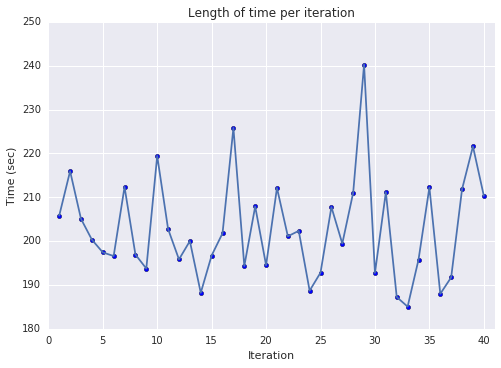

In [ ]:
plotTimes(wikipedia50PageRankTimes)

### 50 Iterations - Top 100

Now we take the top 100 page rank values.

In [ ]:
wikipedia50Top100PageRanks = wikipedia50PageRankResult.takeOrdered(100, lambda x: -x[1])
wikipedia50Top100PageRankValues = { x[0]: x[1] for x in wikipedia50Top100PageRanks }

Perform a hash join of the indices with the top 100 IDs, which we can achieve in a more performant way by broadcasting the tables and generating the join via a filter followed by a map.

In [ ]:
wikipedia50 = pandas.DataFrame( \
    getNamedPageRanks(wikipedia50Top100PageRankValues), \
    columns=['Page Name', 'PageRank'])

wikipedia50.to_csv('wikipedia50.csv')
wikipedia50

,Page Name,PageRank
0,United States,0.001462
1,Animal,0.000666
2,France,0.000640
3,Germany,0.000575
4,Arthropod,0.000450
5,Canada,0.000447
6,Insect,0.000445
7,List of sovereign states,0.000444
8,United Kingdom,0.000433
9,India,0.000428


## Evaluate PageRank Results

> Plot the pagerank values for the top 100 pages resulting from the 50 iterations run. Then plot the pagerank values for the same 100 pages that resulted from the 10 iterations run.  Comment on your findings.

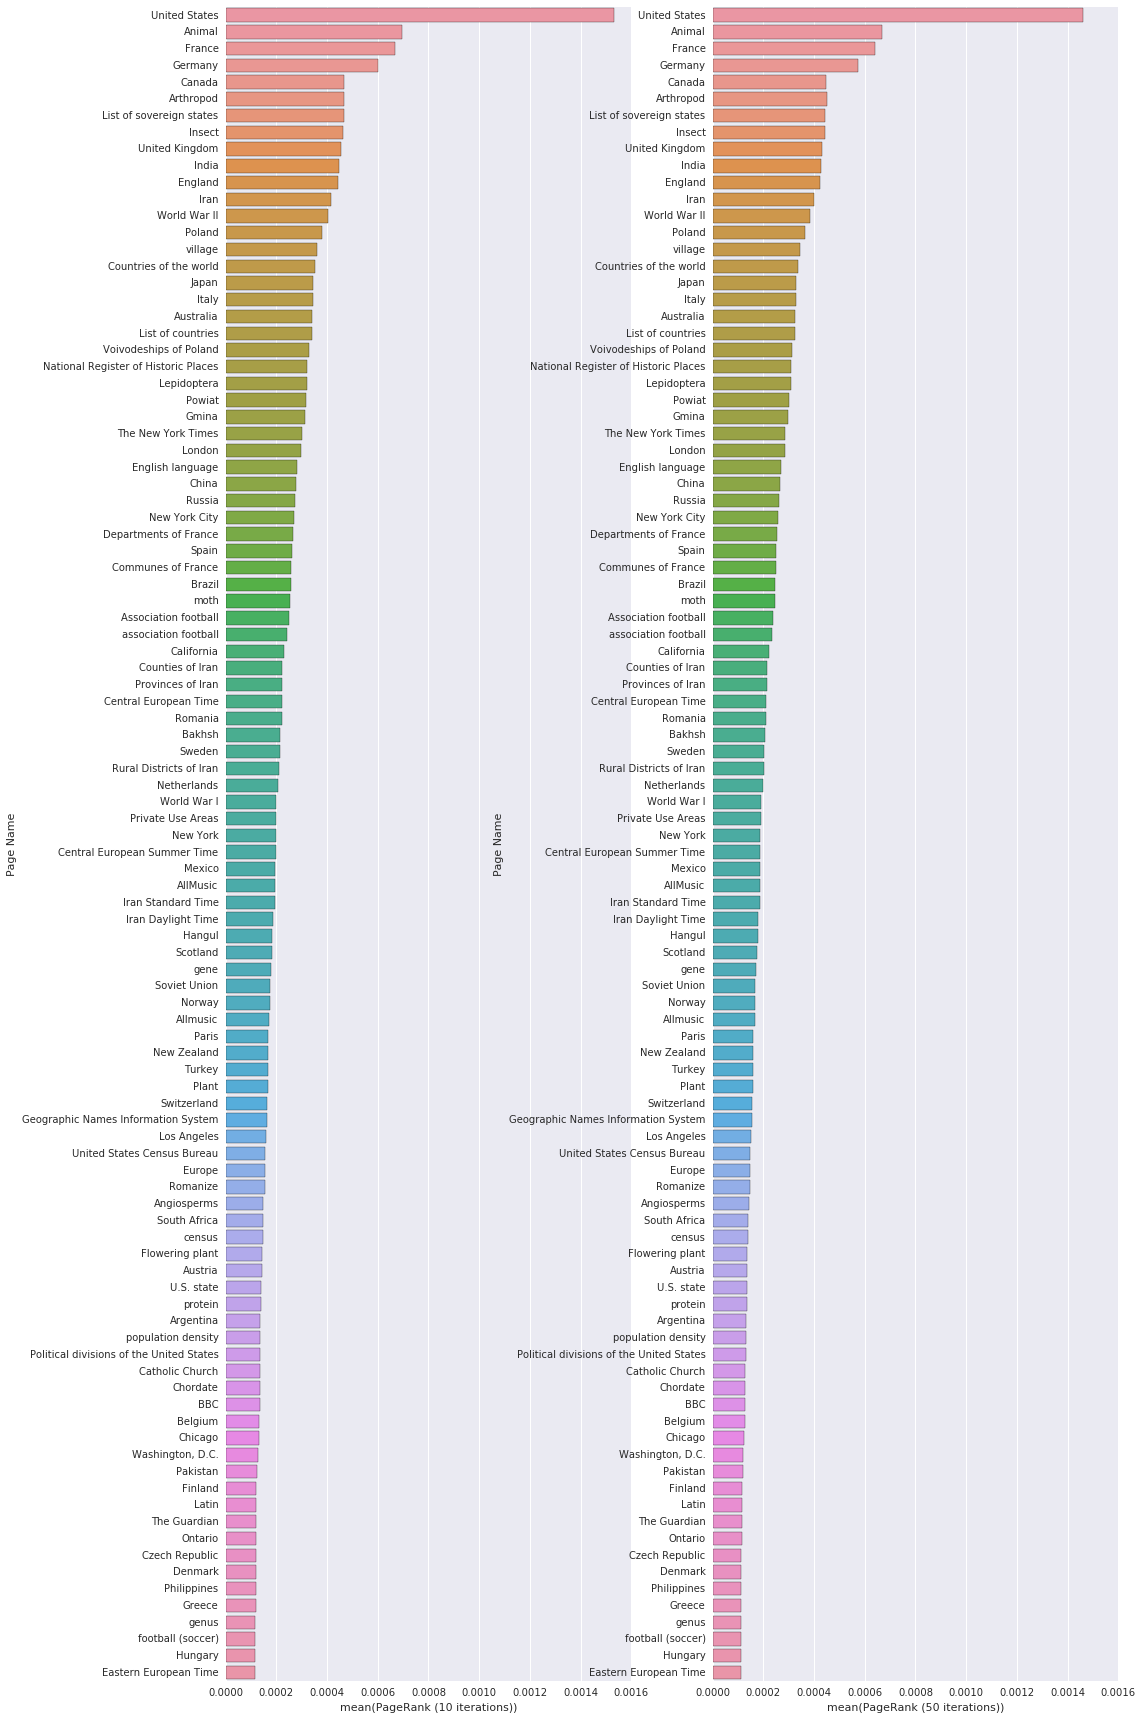

In [ ]:
wikipediaMerged = wikipedia10.merge( \
    wikipedia50, on=['Page Name'], suffixes=[' (10 iterations)', ' (50 iterations)'])

fig, axes = plt.subplots(1, 2, figsize=(16, 30))

seaborn.barplot(x='PageRank (10 iterations)', y='Page Name', data=wikipediaMerged, ax=axes[0])
seaborn.barplot(x='PageRank (50 iterations)', y='Page Name', data=wikipediaMerged, ax=axes[1])

> Have the top 100 ranked pages changed? Have the pagerank values changed? Explain.

We can check if the membership changed using set intersection.

In [ ]:
top100Nodes10 = [x[0] for x in wikipedia10Top100PageRanks]
top100Nodes50 = [x[0] for x in wikipedia50Top100PageRanks]

intersection = set(top100Nodes10) & set(top100Nodes50)
print 'Intersection:', len(intersection), 'nodes'

Intersection: 100 nodes


We can also check the Levenshtein distance between the two rankings to see how much the rankings themselves have changed.

In [ ]:
# Borrowed under Creative Commons
# http://hetland.org/coding/python/levenshtein.py

def levenshtein(a,b):
    "Calculates the Levenshtein distance between a and b."
    n, m = len(a), len(b)
    if n > m:
        # Make sure n <= m, to use O(min(n,m)) space
        a,b = b,a
        n,m = m,n

    current = range(n+1)
    for i in range(1,m+1):
        previous, current = current, [i]+[0]*n
        for j in range(1,n+1):
            add, delete = previous[j]+1, current[j-1]+1
            change = previous[j-1]
            if a[j-1] != b[i-1]:
                change = change + 1
            current[j] = min(add, delete, change)

    return current[n]

print 'Levenshtein distance:', levenshtein(top100Nodes10, top100Nodes50)

Levenshtein distance: 23


This means that even though the top 100 has not changed in terms of the nodes themselves, the rankings have shifted slightly during the additional iterations. Let's identify which ones changed.

In [ ]:
[(x, y) for x, y in zip(top100Nodes10, top100Nodes50) if x != y]

[(u'Canada', u'Arthropod'),
 (u'Arthropod', u'Canada'),
 (u'List of sovereign states', u'Insect'),
 (u'Insect', u'List of sovereign states'),
 (u'Australia', u'List of countries'),
 (u'List of countries', u'Australia'),
 (u'Brazil', u'moth'),
 (u'moth', u'Brazil'),
 (u'World War I', u'Private Use Areas'),
 (u'Private Use Areas', u'World War I'),
 (u'AllMusic', u'Iran Standard Time'),
 (u'Iran Standard Time', u'AllMusic'),
 (u'Switzerland', u'Geographic Names Information System'),
 (u'Geographic Names Information System', u'Switzerland'),
 (u'United States Census Bureau', u'Romanize'),
 (u'Europe', u'United States Census Bureau'),
 (u'Romanize', u'Europe'),
 (u'U.S. state', u'protein'),
 (u'protein', u'U.S. state'),
 (u'population density', u'Political divisions of the United States'),
 (u'Political divisions of the United States', u'population density'),
 (u'Latin', u'The Guardian'),
 (u'The Guardian', u'Latin'),
 (u'Denmark', u'Philippines'),
 (u'Philippines', u'Denmark')]

Because the zip is ordered, and everything mismatched is immediately flipped, many of the top 100 are switching places back and forth as the PageRank continues to iterate, with one exception being a set of three (United States Census Bureau, Romanize, Europe) that appear to be switching places.

In [ ]:
allPageRanks = wikipediaMerged[['PageRank (10 iterations)', 'PageRank (50 iterations)']].values
maxChange = numpy.max(numpy.divide(allPageRanks[:,0], allPageRanks[:,1]) - 1)
maxChangeIndex = numpy.argmax(numpy.divide(allPageRanks[:,0], allPageRanks[:,1]) - 1)

print 'maximum change: {:.3%}'.format(maxChange)
wikipediaMerged[maxChangeIndex:maxChangeIndex+1]

maximum change: 5.478%


,Page Name,PageRank (10 iterations),PageRank (50 iterations)
81,Catholic Church,0.000136,0.000128


As we can see above, even though the Levenshtein distance appears to be large, the actual absolute values in switching page ranks are fairly small, with the maximum relative percentage change being 5.48%.

# HW 13.3: Spark GraphX versus your implementation of PageRank

## Provide utility method to run GraphX PageRank

First, we provide a utility library which will let us run page rank just by passing a file name.

In [ ]:
%%writefile PageRank.scala
import java.io._
import org.apache.spark._
import org.apache.spark.graphx._
import org.apache.spark.graphx.lib._
import org.apache.spark.rdd.RDD

/**
 * Retrieve edges from a single line in the input file
 */
def getEdges(line:String): List[Edge[Int]] = {
  val splitLine = line.split("\t")

  val label:String = splitLine(0)
  val re = "'([^']*)'".r

  val matchList = (re findAllIn splitLine(1)).matchData.toList
  matchList.map { matchItem => Edge(label.toLong, matchItem.group(1).toLong, 1) }
}

/**
 * Run PageRank against the specified file and take the top N results
 */
def pageRank(inputFileName:String, outputFileName:String, iterations:Int, topN:Int) {
    val edges = sc.textFile(inputFileName).flatMap(getEdges).cache()
    edges.count()

    val graph:Graph[Any,Int] = Graph.fromEdges(edges, 1)

    val start = System.nanoTime()
    val pageRank = PageRank.run(graph, numIter=iterations, resetProb=0.15).vertices
    val topPageRank = pageRank.takeOrdered(topN)(Ordering[Double].reverse.on { x => x._2 })
    val end = System.nanoTime()

    sc.parallelize(topPageRank).saveAsTextFile(outputFileName)

    val writer = new PrintWriter(new File(outputFileName + ".time_elapsed"))
    writer.println((end - start) * 1e-9)
    writer.close()
}

Overwriting PageRank.scala


## Check implementation against test data

Before we run the shell script, we'll make sure that our log4j.properties suppresses INFO level logging so that we only print out WARN or above.

In [ ]:
!sudo sed -i 's/INFO/WARN/g' {os.environ['SPARK_HOME']}/conf/log4j.properties

An `Edge` in spark requires that we use a numbered edge graph (all vertex identifiers are 64-bit integers rather than strings), so we start by retrieving a different file for our test.

In [ ]:
if not os.path.isfile('PageRank-test_indexed.txt'):
    !wget -qq https://www.dropbox.com/sh/2c0k5adwz36lkcw/AACf_33TeM7rKfEhjEoNmMCaa/PageRank-test_indexed.txt
    !hdfs dfs -copyFromLocal PageRank-test_indexed.txt

Now we submit our script to the Spark shell. Given that we are just using the test set, we don't need to provide the extra configuration options for the shell.

In [ ]:
%%writefile TestPageRank.scala
:load PageRank.scala
pageRank("PageRank-test_indexed.txt", "scala_test", 40, 11)

Overwriting TestPageRank.scala


In [ ]:
!echo >> TestPageRank.scala
!hdfs dfs -rm -r -f -skipTrash scala_test > /dev/null
!cat TestPageRank.scala | spark-shell > /dev/null 2>&1
!hdfs dfs -cat scala_test/*

(2,3.560429918779537)
(3,3.1757908007345232)
(5,0.7503552818569399)
(6,0.3626006631927996)
(4,0.3626006631927996)
(1,0.30410528185693986)
(8,0.15)
(10,0.15)
(11,0.15)
(9,0.15)
(7,0.15)


Note: although the rankings end up the same for GraphX vs. our home grown implementation, the PageRank values are different. This is due to differences in normalization, dangling mass distribution and initialization values.

* **Normalization**: our implementation has PageRanks of all nodes sum to 1. GraphX does not.
* **Dangling mass distribution**: we distribute dangling mass. GraphX sets PageRank of dangling nodes to be alpha.
* **Initialization values**: we initialize the PageRank to 1/n. GraphX initalizes to 1.

## Check implementation against Wikipedia data set

In order to run efficiently, we'll need to stop our current Spark context.

In [ ]:
sc.stop()

### 10 Iterations - Execution

> Run the Spark  GraphX PageRank implementation on the Wikipedia dataset for 10 iterations,
and display the top 100 ranked nodes (with alpha = 0.85).

In [ ]:
%%writefile Wikipedia10PageRank.scala
:load PageRank.scala
pageRank("all-pages-indexed-out.txt", "scala_wikipedia10", 10, 100)

Overwriting Wikipedia10PageRank.scala


In [ ]:
!echo >> Wikipedia10PageRank.scala
!hdfs dfs -rm -r -f -skipTrash scala_wikipedia10 > /dev/null

!cat Wikipedia10PageRank.scala | \
    spark-shell --master yarn-client --num-executors {executor_count} \
    --executor-memory {memory_per_executor}M --executor-cores {cores_per_executor} \
    > /dev/null 2>&1

!cat scala_wikipedia10.time_elapsed

239.543514528


### 50 Iterations - Execution

> Run your PageRank implementation on the Wikipedia dataset for 50 iterations,
and display the top 100 ranked nodes (with teleportation factor of 0.15). 

In [ ]:
%%writefile Wikipedia50PageRank.scala
:load PageRank.scala
pageRank("all-pages-indexed-out.txt", "scala_wikipedia50", 50, 100)

Overwriting Wikipedia50PageRank.scala


In [ ]:
!echo >> Wikipedia50PageRank.scala
!hdfs dfs -rm -r -f -skipTrash scala_wikipedia50 > /dev/null

!cat Wikipedia50PageRank.scala | \
    spark-shell --master yarn-client --num-executors {executor_count} \
    --executor-memory {memory_per_executor}M --executor-cores {cores_per_executor} \
    > /dev/null 2>&1

!cat scala_wikipedia50.time_elapsed

696.389905248


## Evaluate PageRank Results

We'll need to restart our Spark context to redo our analysis. We'll also need to reload the indexes RDD.

In [ ]:
sc = SparkContext(conf=conf)
wikipediaIndicesRDD = sc.textFile('indices.txt')

### Check top 100 changes

> Have the top 100 ranked pages changed? Comment on your findings. Plot both 100 curves.

Both plots end up being very similar, with the curves nearly falling right on top of each other.

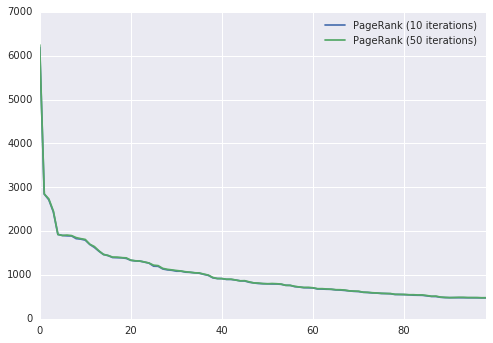

In [ ]:
graphxWikipedia10Top100PageRanks = sc.textFile('scala_wikipedia10').map(eval).collect()
graphxWikipedia10Top100PageRankValues = { str(x[0]): x[1] for x in graphxWikipedia10Top100PageRanks }

graphxWikipedia10 = pandas.DataFrame( \
    getNamedPageRanks(graphxWikipedia10Top100PageRankValues), \
    columns=['Page Name', 'PageRank'])

graphxWikipedia50Top100PageRanks = sc.textFile('scala_wikipedia50').map(eval).collect()
graphxWikipedia50Top100PageRankValues = { str(x[0]): x[1] for x in graphxWikipedia50Top100PageRanks }

graphxWikipedia50 = pandas.DataFrame( \
    getNamedPageRanks(graphxWikipedia50Top100PageRankValues), \
    columns=['Page Name', 'PageRank'])

graphxWikipediaMerged = graphxWikipedia10.merge( \
    graphxWikipedia50, on=['Page Name'], suffixes=[' (10 iterations)', ' (50 iterations)'])

graphxWikipediaMerged.plot()

We can check if the membership changed using set intersection.

In [ ]:
graphxTop100Nodes10 = [str(x[0]) for x in graphxWikipedia10Top100PageRanks]
graphxTop100Nodes50 = [str(x[0]) for x in graphxWikipedia50Top100PageRanks]

intersection = set(graphxTop100Nodes10) & set(graphxTop100Nodes50)
print 'Intersection:', len(intersection), 'nodes'

Intersection: 99 nodes


We can also check the Levenshtein distance between the two rankings to see how much the rankings themselves have changed.

In [ ]:
print 'Levenshtein distance:', levenshtein(graphxTop100Nodes10, graphxTop100Nodes50)

Levenshtein distance: 27


> Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete this job.

* **Instance Type**: [Memory Optimized](https://aws.amazon.com/ec2/instance-types/#memory-optimized)
* **Instance Class**: r3.xlarge
* **Cluster Size**: 10 nodes
* **Job Completion Time**: ???

### Compare runtimes

> Put the runtime results of HW13.2 and HW13.3 in a tabular format (with rows corresponding to implemention and columns corresponding to experiment setup (10 iterations, 50 iterations)). Discuss the run times and explain the differences.

In [ ]:
runtimes = {
    'Manual': {'10 iterations': (35*60+11)/60, '50 iterations': (2*3600+15*60+17)/60},
    'GraphX': {'10 iterations': (240)/60, '50 iterations': (13*60+3)/60}
}

pandas.DataFrame.from_dict(runtimes, orient='index')

,50 iterations,10 iterations
GraphX,13.050000,4.000000
Manual,135.283333,35.183333


GraphX produces runtimes that are much shorter than our home grown implementation. While GraphX ran 10 iterations in less than 5 minutes after accounting for data materialization, while our home grown implementation took over 30 minutes after accounting for data materialization.

Although the home grown implementation could utilize the 10 iteration run as a starting point and only run 40 more iterations, there was still a significant improvement when using GraphX. The home grown implementation took approximately 170 minutes (sum of the 10 iteration and 40 iteration runs), while GraphX took less than 15 minutes.

Ultimately, though, 3.5 minute iterations are approximately 7 times faster than Hadoop, and GraphX is almost 10 times faster than the manual implementation. This means that we have an almost 70x speedup by using GraphX.

There are likely some optimizations used in the GraphX algorithm that we are not exploiting, perhaps more efficient partitioning or caching. It's also possible that the representation allows for GraphX's improved performance.

### Compare results

> Plot the pagerank values for the top 100 pages resulting from the 50 iterations run (using GraphX). Then plot the pagerank values for the same 100 pages that resulted from the 50 iterations run of your homegrown pagerank implementation.  Comment on your findings.

> Have the top 100 ranked pages changed? Have the pagerank values changed? Explain.

The PageRank values for the GraphX implementation and our home grown implementation are not immediately comparable. Our home grown implementation distributes the dangling mass to all nodes in the graph in each iteration, while the GraphX implementation does not (all dangling nodes have PageRank values equal to alpha). Additionally, the PageRank values in the GraphX implementation are not normalized, thus they do not sum to 1.

To begin comparing, we need to normalize both of the PageRank values by dividing each PageRank value by the max value for each implementation.

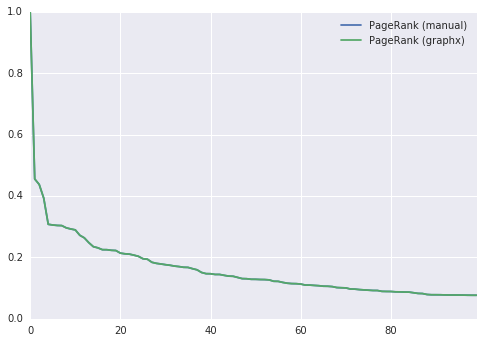

In [ ]:
wikipedia50 = pandas.DataFrame.from_csv('wikipedia50.csv')
manualGraphXCompare = wikipedia50.merge(graphxWikipedia50, on=['Page Name'], suffixes=[' (manual)', ' (graphx)'])

manualGraphXCompare['PageRank (manual)'] = \
    manualGraphXCompare['PageRank (manual)'] / manualGraphXCompare['PageRank (manual)'].max()

manualGraphXCompare['PageRank (graphx)'] = \
    manualGraphXCompare['PageRank (graphx)'] / manualGraphXCompare['PageRank (graphx)'].max()

manualGraphXCompare.plot()

After normalization, we see that the curves are nearly identical.

# HW 13.4: Criteo Phase 2 baseline

> The Criteo data for this challenge is located in the following S3/Dropbox buckets:

> On Dropbox see:
> * https://www.dropbox.com/sh/dnevke9vsk6yj3p/AABoP-Kv2SRxuK8j3TtJsSv5a?dl=0

> Raw Data:  (Training, Validation and Test data)
> * https://console.aws.amazon.com/s3/home?region=us-west-1#&bucket=criteo-dataset&prefix=rawdata/

> Hashed Data: Training, Validation and Test data in hash encoded (10,000 buckets) and sparse representation
> * https://console.aws.amazon.com/s3/home?region=us-west-1#&bucket=criteo-dataset&prefix=processeddata/

In [ ]:
if not os.path.isdir('processeddata'):
    !mkdir processeddata
    !aws s3 sync s3://criteo-dataset/processeddata processeddata
    !hdfs dfs -copyFromLocal processeddata

First, we need functions that can load our data files into `LabeledPoint` objects used in logistic regression.

In [ ]:
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.regression import LabeledPoint

# Deserialize a LabeledPoint that was serialized as a tuple

def moduloPoint(numBuckets, data):
    label, sparse = eval(data)
    oldBuckets, indices, values = sparse

    features = {}

    for index, value in zip(indices, values):
        modIndex = index % numBuckets

        if modIndex in features:
            features[modIndex] += value
        else:
            features[modIndex] = value

    return LabeledPoint(label, SparseVector(numBuckets, features))

# Load the data as a materialized RDD

cachedDataSets = {}

def getParsedData(numBuckets, subfolders):
    global cachedDataSets

    if 10000 % numBuckets != 0:
        print '10000 %', numBuckets, '!= 0'
        return [sc.emptyRDD()] * len(subfolders)

    # Build the RDDs from the S3 URLs for train, validation, test

    dataRDDs = []

    for subfolder in subfolders:
        now = datetime.today()
        print now, 'Materializing text file RDD for', subfolder

        dataPath = 'processeddata/%s' % subfolder

        if dataPath in cachedDataSets:
            folderRDD = cachedDataSets[dataPath]
        else:
            folderRDD = sc.textFile(dataPath).cache()
            folderRDD.count()

            cachedDataSets[dataPath] = folderRDD

        now = datetime.today()
        print now, 'Materializing parsed RDD for', subfolder

        dataRDD = folderRDD.map(functools.partial(moduloPoint, numBuckets)).cache()
        dataRDD.count()

        dataRDDs.append(dataRDD)

    return dataRDDs

Now we load the 1000 bucket data set.

In [ ]:
%time hashedRawTrainRDD, hashedRawValidationRDD, hashedRawTestRDD = \
    getParsedData(1000, ['train', 'validation', 'test'])

2016-04-29 05:23:19.103827 Materializing text file RDD for train
2016-04-29 05:23:19.104599 Materializing parsed RDD for train
2016-04-29 05:29:06.064387 Materializing text file RDD for validation
2016-04-29 05:29:06.064514 Materializing parsed RDD for validation
2016-04-29 05:29:47.065701 Materializing text file RDD for test
2016-04-29 05:29:47.065954 Materializing parsed RDD for test
CPU times: user 81.2 ms, sys: 36.1 ms, total: 117 ms
Wall time: 7min 11s


## Train the Logistic Regression

> Using the training dataset, validation dataset and testing dataset in the Criteo bucket perform the following experiment:

> Write spark code (borrow from Phase 1 of this project) to train a logistic regression model with the following hyperparameters:

> * Number of buckets for hashing: 1,000
> * Logistic Regression: no regularization term
> * Logistic Regression: step size = 10

Now we perform the linear regression (100 iterations) on the materialized and cached RDD and record the elapsed time for reporting purposes.

In [ ]:
from pyspark.mllib.classification import LogisticRegressionWithSGD

numIters = 100
stepSize = 10.0
regParam = 1e-6
regType = 'none'
includeIntercept = True

%time model = LogisticRegressionWithSGD.train( \
    data=hashedRawTrainRDD, iterations=numIters, step=stepSize, \
    regParam=regParam, regType=regType, intercept=includeIntercept)

CPU times: user 1.37 s, sys: 420 ms, total: 1.79 s
Wall time: 2min 9s


> Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete this job.

* **Instance Type**: [Memory Optimized](https://aws.amazon.com/ec2/instance-types/#memory-optimized)
* **Instance Class**: r3.xlarge
* **Cluster Size**: 10 nodes
* **Job Completion Time**: about 2 minutes

## Evaluate Logistic Regression

> Report in tabular form the AUC value (https://en.wikipedia.org/wiki/Receiver_operating_characteristic) for the Training, Validation, and Testing datasets.

First, we need to compute those metrics.

In [ ]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

modelBroadcast = sc.broadcast(model)

# Compute the scores and labels

def getScoresAndLabels(point):
    return float(modelBroadcast.value.predict(point.features)), point.label

# Compute the area under the ROC curve

def getAreaUnderROC(dataRDD):
    scoresAndLabelsRDD = dataRDD.map(getScoresAndLabels)
    metrics = BinaryClassificationMetrics(scoresAndLabelsRDD)
    return metrics.areaUnderROC

# Run code against all data sets

hashedRawTrainAUC = getAreaUnderROC(hashedRawTrainRDD)
hashedRawValidationAUC = getAreaUnderROC(hashedRawValidationRDD)
hashedRawTestAUC = getAreaUnderROC(hashedRawTestRDD)

Next, we'll put it into a nice table.

In [ ]:
pandas.DataFrame(data=[
    ('Train', hashedRawTrainAUC),
    ('Validation', hashedRawValidationAUC),
    ('Test', hashedRawTestAUC)
], columns=['Data Set', 'Area Under ROC Curve'])

,Data Set,Area Under ROC Curve
0,Train,0.587922
1,Validation,0.588109
2,Test,0.587916


> Report in tabular form  the logLossTest for the Training, Validation, and Testing datasets.

First, we need to compute this metric.

In [ ]:
# Keep the prediction bounded to minimize log loss

def getBoundedPrediction(features):
    rawPrediction = features.dot(modelBroadcast.value.weights) + modelBroadcast.value.intercept

    # Bound the raw prediction value
    rawPrediction = min(rawPrediction, 20)
    rawPrediction = max(rawPrediction, -20)

    return 1.0 / (1.0 + exp(-rawPrediction))

# Retrieve a bounded score and label

def getBoundedScoresAndLabels(point):
    return getBoundedPrediction(point.features), point.label

# Compute an individual log loss using the same code as the CTR assignment

def computeLogLoss(scoreAndLabel):
    p, y = scoreAndLabel

    epsilon = 10e-12
    if p == 0:
        prob = epsilon
    elif p == 1:
        prob = 1 - epsilon
    else:
        prob = p * 1.0
    return -(y * log(prob) + (1.0 - y) * log(1.0 - prob))

# Compute the average log loss using the same code as the CTR assignment

def getAverageLogLoss(dataRDD):
    scoresAndLabelsRDD = dataRDD.map(getBoundedScoresAndLabels)
    logLossRDD = scoresAndLabelsRDD.map(computeLogLoss)
    return logLossRDD.mean()

# Run code against all data sets

hashedRawTrainLogLoss = getAverageLogLoss(hashedRawTrainRDD)
hashedRawValidationLogLoss = getAverageLogLoss(hashedRawValidationRDD)
hashedRawTestLogLoss = getAverageLogLoss(hashedRawTestRDD)

Next, we'll put it into a nice table.

In [ ]:
pandas.DataFrame(data=[
    ('Train', hashedRawTrainLogLoss),
    ('Validation', hashedRawValidationLogLoss),
    ('Test', hashedRawTestLogLoss)
], columns=['Data Set', 'Log Loss'])

,Data Set,Log Loss
0,Train,0.497478
1,Validation,0.497643
2,Test,0.497676


# HW 13.5: Criteo Phase 2 hyperparameter tuning

## Unpersist old RDDs

We can run out of memory quickly on our Spark cluster if we persist all of the RDDs we've computed so far. While we cache the data loading, we'll uncache the parsed data.

In [ ]:
hashedRawTrainRDD.unpersist()
hashedRawValidationRDD.unpersist()
hashedRawTestRDD.unpersist()

PythonRDD[620] at RDD at PythonRDD.scala:43

## Train the Logistic Regression

> Using the training dataset, validation dataset and testing dataset in the Criteo bucket perform the following experiments:

> Write spark code (borrow from Phase 1 of this project) to train a logistic regression model with various hyperparameters. Do a gridsearch of the hyperparameter space and determine optimal settings using the validation set.

> * Number of buckets for hashing: 1,000, 10,000, .... explore different values  here
> * Logistic Regression: regularization term: [1e-6, 1e-3]  explore other  values here also
> * Logistic Regression: step size: explore different step sizes. Focus on a stepsize of 1 initially

## Initial training

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder

# Provide a function which computes the log loss on the validation set
# after training the model on the training set.

def getModelMetrics(trainRDD, validationRDD, parameters):
    global modelBroadcast

    now = datetime.today()
    print now, parameters

    t0 = time.time()
    model = LogisticRegressionWithSGD.train(data=trainRDD, iterations=numIters, **parameters)
    t1 = time.time()

    elapsedTime = t1 - t0

    modelBroadcast = sc.broadcast(model)
    return elapsedTime, getAreaUnderROC(validationRDD), getAverageLogLoss(validationRDD)

# Iterate over all desired bucket sizes and parameter combinations and
# compute the metrics. Build up a list of all the results for later steps.

def getTrainingResults(bucketSizes, builder):
    modelMetrics = []

    for bucketSize in bucketSizes:
        trainRDD, validationRDD = getParsedData(bucketSize, ['train', 'validation'])

        for parameters in builder.build():

            elapsedTime, areaUnderROC, logLoss = getModelMetrics(trainRDD, validationRDD, parameters)

            parameters['bucketSize'] = bucketSize

            parameters['elapsedTime'] = elapsedTime
            parameters['areaUnderROC'] = areaUnderROC
            parameters['logLoss'] = logLoss

            modelMetrics.append(parameters)

        trainRDD.unpersist()
        validationRDD.unpersist()

    return modelMetrics

# Check the model for a small number of parameters across 3 bucket sizes

builder = ParamGridBuilder()
builder.addGrid('step', [10, 1, 0.1])
builder.addGrid('regParam', [1e-6, 1e-3, 1e-1])
builder.addGrid('regType', ['l2'])
builder.addGrid('intercept', [True])

%time trainingResults = getTrainingResults([100, 1000, 10000], builder)
df = pandas.DataFrame(trainingResults)

2016-04-29 07:38:24.914425 Materializing text file RDD for train
2016-04-29 07:38:24.914747 Materializing parsed RDD for train
2016-04-29 07:43:38.600005 Materializing text file RDD for validation
2016-04-29 07:43:38.600125 Materializing parsed RDD for validation
2016-04-29 07:44:18.769973 {'regParam': 1e-06, 'step': 10, 'intercept': True, 'regType': 'l2'}
2016-04-29 07:46:32.709122 {'regParam': 1e-06, 'step': 1, 'intercept': True, 'regType': 'l2'}
2016-04-29 07:48:21.495452 {'regParam': 1e-06, 'step': 0.1, 'intercept': True, 'regType': 'l2'}
2016-04-29 07:49:51.651813 {'regParam': 0.001, 'step': 10, 'intercept': True, 'regType': 'l2'}
2016-04-29 07:51:40.239929 {'regParam': 0.001, 'step': 1, 'intercept': True, 'regType': 'l2'}
2016-04-29 07:53:43.401491 {'regParam': 0.001, 'step': 0.1, 'intercept': True, 'regType': 'l2'}
2016-04-29 07:55:07.423169 {'regParam': 0.1, 'step': 10, 'intercept': True, 'regType': 'l2'}
2016-04-29 07:57:04.876932 {'regParam': 0.1, 'step': 1, 'intercept': True

After completing the training, we can take a look at the log loss ordering.

In [ ]:
df.sort_values(by=['logLoss'], ascending=True).head(10)

,areaUnderROC,bucketSize,elapsedTime,intercept,logLoss,regParam,regType,step
18,0.588110,10000,132.000550,True,0.497643,0.000001,l2,10.0
21,0.584856,10000,165.985974,True,0.498389,0.001000,l2,10.0
9,0.582249,1000,146.544066,True,0.505676,0.000001,l2,10.0
12,0.579034,1000,142.434425,True,0.505941,0.001000,l2,10.0
19,0.527311,10000,155.052287,True,0.521904,0.000001,l2,1.0
22,0.526536,10000,164.570358,True,0.522045,0.001000,l2,1.0
10,0.525496,1000,145.645847,True,0.523577,0.000001,l2,1.0
13,0.524822,1000,146.166606,True,0.523708,0.001000,l2,1.0
24,0.500114,10000,158.187310,True,0.535102,0.100000,l2,10.0
25,0.500089,10000,158.208224,True,0.536422,0.100000,l2,1.0


Among the top 10, we observe the following trends in log loss.

* a bucket size of 10,000 has a slight advantage over a bucket size of 1,000
* a regularization parameter of $10^{-6}$ has a slight advantage over a regularization parameter of $10^{-3}$
* a larger step size of 10 has a slight advantage over a smaller step size of 1

In [ ]:
df.sort_values(by=['areaUnderROC'], ascending=False).head(10)

,areaUnderROC,bucketSize,elapsedTime,intercept,logLoss,regParam,regType,step
3,0.590576,100,87.959479,True,0.979312,0.001000,l2,10.0
18,0.588110,10000,132.000550,True,0.497643,0.000001,l2,10.0
21,0.584856,10000,165.985974,True,0.498389,0.001000,l2,10.0
9,0.582249,1000,146.544066,True,0.505676,0.000001,l2,10.0
12,0.579034,1000,142.434425,True,0.505941,0.001000,l2,10.0
0,0.571511,100,109.984050,True,1.108461,0.000001,l2,10.0
19,0.527311,10000,155.052287,True,0.521904,0.000001,l2,1.0
6,0.526950,100,96.487581,True,1.020920,0.100000,l2,10.0
22,0.526536,10000,164.570358,True,0.522045,0.001000,l2,1.0
10,0.525496,1000,145.645847,True,0.523577,0.000001,l2,1.0


Among the top 10, we observe the following trends in the AUC:

* while the best is a bucket size of 100, larger buckets are more common
* a larger regularization parameter of $10^{-3}$ has a slight advantage over a regularization parameter of $10^{-6}$, which is the opposite of log loss
* a larger step size is consistently better

## Additional training

It looks like having 10,000 buckets consistently produces lower logloss values, let's stick with that number. We'll get more granular with the smaller regularization parameters between $10^{-6}$ and $10^{-3}$ and step sizes between 1 and 10.

In [ ]:
builder = ParamGridBuilder()
builder.addGrid('step', [10, 5, 1])
builder.addGrid('regParam', [1e-6, 1e-5, 1e-4, 1e-3])
builder.addGrid('regType', ['l2'])
builder.addGrid('intercept', [True])

trainingResults = getTrainingResults([10000], builder)
df2 = pandas.DataFrame(trainingResults)

2016-04-29 09:24:53.730183 Materializing text file RDD for train
2016-04-29 09:24:53.730550 Materializing parsed RDD for train
2016-04-29 09:30:19.541226 Materializing text file RDD for validation
2016-04-29 09:30:19.541395 Materializing parsed RDD for validation
2016-04-29 09:31:01.880122 {'regParam': 1e-06, 'step': 10, 'intercept': True, 'regType': 'l2'}
2016-04-29 09:34:12.325766 {'regParam': 1e-06, 'step': 5, 'intercept': True, 'regType': 'l2'}
2016-04-29 09:37:15.605319 {'regParam': 1e-06, 'step': 1, 'intercept': True, 'regType': 'l2'}
2016-04-29 09:40:14.997325 {'regParam': 1e-05, 'step': 10, 'intercept': True, 'regType': 'l2'}
2016-04-29 09:43:21.045821 {'regParam': 1e-05, 'step': 5, 'intercept': True, 'regType': 'l2'}
2016-04-29 09:46:25.964345 {'regParam': 1e-05, 'step': 1, 'intercept': True, 'regType': 'l2'}
2016-04-29 09:49:27.267297 {'regParam': 0.0001, 'step': 10, 'intercept': True, 'regType': 'l2'}
2016-04-29 09:52:26.518519 {'regParam': 0.0001, 'step': 5, 'intercept': Tr

After completing the training, we can take a look at the log loss ordering.

In [ ]:
df2.sort_values(by=['logLoss'], ascending=True).head(10)

,areaUnderROC,bucketSize,elapsedTime,intercept,logLoss,regParam,regType,step
0,0.588110,10000,168.713610,True,0.497643,0.000001,l2,10
3,0.588216,10000,160.240905,True,0.497644,0.000010,l2,10
6,0.588056,10000,156.854272,True,0.497702,0.000100,l2,10
9,0.584856,10000,165.952102,True,0.498389,0.001000,l2,10
1,0.575065,10000,159.051584,True,0.503715,0.000001,l2,5
4,0.575048,10000,161.799162,True,0.503719,0.000010,l2,5
7,0.574835,10000,159.620154,True,0.503760,0.000100,l2,5
10,0.572806,10000,159.721988,True,0.504190,0.001000,l2,5
2,0.527311,10000,157.057871,True,0.521904,0.000001,l2,1
5,0.527302,10000,159.505818,True,0.521906,0.000010,l2,1


In terms of log loss, the smallest regularization parameter and the largest step size performs the best.

In [ ]:
df2.sort_values(by=['areaUnderROC'], ascending=False).head(10)

,areaUnderROC,bucketSize,elapsedTime,intercept,logLoss,regParam,regType,step
3,0.588216,10000,160.240905,True,0.497644,0.000010,l2,10
0,0.588110,10000,168.713610,True,0.497643,0.000001,l2,10
6,0.588056,10000,156.854272,True,0.497702,0.000100,l2,10
9,0.584856,10000,165.952102,True,0.498389,0.001000,l2,10
1,0.575065,10000,159.051584,True,0.503715,0.000001,l2,5
4,0.575048,10000,161.799162,True,0.503719,0.000010,l2,5
7,0.574835,10000,159.620154,True,0.503760,0.000100,l2,5
10,0.572806,10000,159.721988,True,0.504190,0.001000,l2,5
2,0.527311,10000,157.057871,True,0.521904,0.000001,l2,1
5,0.527302,10000,159.505818,True,0.521906,0.000010,l2,1


Just as was the case for log loss, the smallest regularization parameter and the largest step size performs the best with respect to the area under the ROC curve.

## Training timing

> Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete this job.

The times for the training itself were stored in a column, and that is summed up here.

In [ ]:
print (df['elapsedTime'].sum() + df2['elapsedTime'].sum()) / 60

89.9266285539


So in total, the two grid searches required an hour and a half in training time scanning the different parameter values for bucket size, regularization parameter, and step size required an hour and a half.

* **Instance Type**: [Memory Optimized](https://aws.amazon.com/ec2/instance-types/#memory-optimized)
* **Instance Class**: r3.xlarge
* **Cluster Size**: 10 nodes
* **Job Completion Time**: almost an hour and a half

## Evaluate the Logistic Regression

> Report in tabular form and using heatmaps the AUC values (https://en.wikipedia.org/wiki/Receiver_operating_characteristic) for the Training, Validation, and Testing datasets.
Report in tabular form and using heatmaps  the logLossTest for the Training, Validation, and Testing datasets.

> Don't forget to put a caption on your tables (above the table) and on your heatmap figures (put caption below figures) detailing the experiment associated with each table or figure (data, algorithm used, parameters and settings explored.

First, we print out the raw dictionary so that we can perform the analysis without having to wait for the whole thing to complete again.

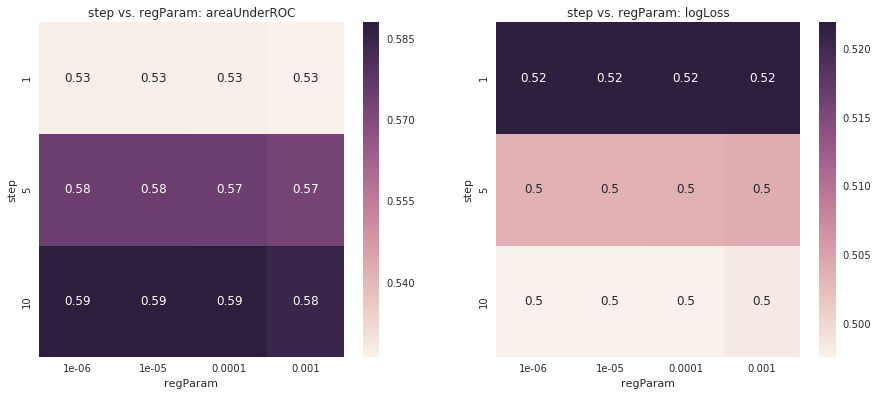

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for i, measure in zip(range(2), ['areaUnderROC', 'logLoss']):
    pivot_df2 = df2.pivot('step', 'regParam', measure)
    seaborn.heatmap(pivot_df2, ax=axes[i], annot=True)
    axes[i].set_title('step vs. regParam: ' + measure)

## Reflect on the Evaluation of the Logistic Regression

> Discuss the optimal setting to solve this problem  in terms of the following:
> * Features
> * Learning algorithm
> * Spark cluster

> Justify your recommendations based on your experimental results and cross reference with table numbers and figure numbers. Also highlight key results with annotations, both textual and line and box based, on your tables and graphs.

### Features

Increasing the number of buckets slightly improves the average log loss while increasing the complexity of the model; it shifts from approximately 0.582 for a small number of buckets to 0.588 at ten buckets. Even though this small improvement incrases the number of features by a factor of 10 (and it would be more parsimonious to chooses the 1,000 model), the recommendation would be use 10,000 buckets in the logistic regression.

### Learning Algorithm

In the logistic regression model, the hyperparameters of regularization parameter = 1e-6 and step size = 5 produce the lowest logloss value on the validation data. Therefore, the recommendation would be to use these values for regularization parameters.

### Spark Cluster

One of the problems in this assignment was making sure we had sufficient memory to hold the training and validation data sets. Therefore, the recommendation is to make sure that many executors are available and each executor has lots of free memory to dedicate to solving this problem.

However, unless you request a very large cluster, you need to frequently unpersist the values in order to allow for the next iteration of grid search. This makes it more difficult to re-test values within the grid search without having to re-parse the data set. This lead to the strategy of running a smaller set of tests to identify the most appropriate bucket size followed by more fine-grained testing of candidate values.